<h1 align=center> Facial Emotion Recognition using Tensorflow </h1> 

## 1. Imports - Let's go

In [1]:
#@ Importing libraries and packages needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import os
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau

## 2. Importing Dataset

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

## 3. Sampling some examples

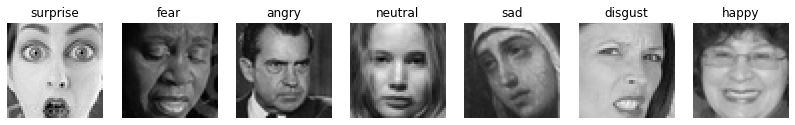

In [3]:
plt.figure(figsize=(14, 22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show();

## 4. Creating training and test sets

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48, 48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical') 

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## 5. Defining Model architecture

In [6]:
def get_model(input_size, classes=7):
    #@ Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    model.compile(optimizer=Adam(lr=0.0001, decay=1e-6), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model 

In [7]:
fernet = get_model((row, col, 1), classes)
fernet.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 256)       2

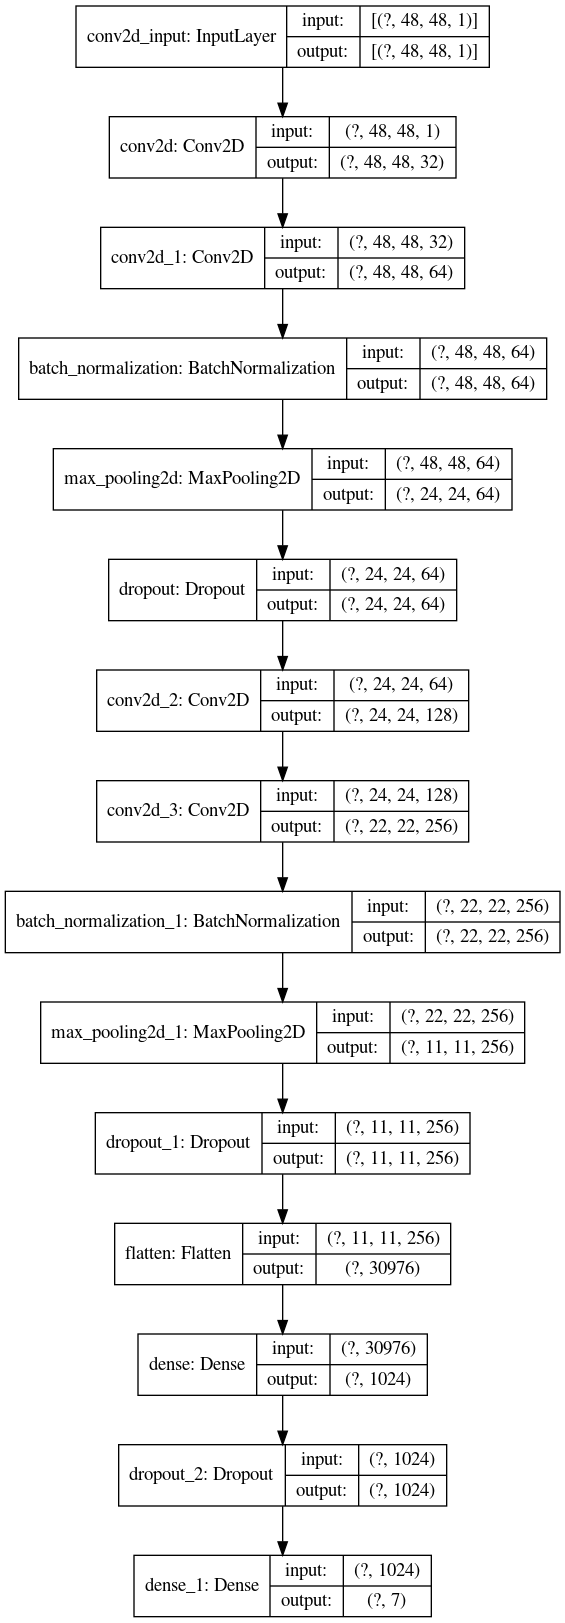

In [8]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True) 

## 6. Callback Functions

In [9]:
chk_path = 'fernet_weights.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger] 

## 7. Training Model

In [10]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60
448/448 [==============================] - ETA: 0s - loss: 4.2994 - accuracy: 0.2797
Epoch 00001: val_loss improved from inf to 4.61406, saving model to fernet_weights.h5
448/448 [==============================] - 108s 240ms/step - loss: 4.2994 - accuracy: 0.2797 - val_loss: 4.6141 - val_accuracy: 0.3165
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.5035 - accuracy: 0.3396
Epoch 00002: val_loss improved from 4.61406 to 3.12224, saving model to fernet_weights.h5
448/448 [==============================] - 35s 78ms/step - loss: 3.5035 - accuracy: 0.3396 - val_loss: 3.1222 - val_accuracy: 0.4142
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 2.9953 - accuracy: 0.3740
Epoch 00003: val_loss improved from 3.12224 to 2.66033, saving model to fernet_weights.h5
448/448 [==============================] - 34s 76ms/step - loss: 2.9953 - accuracy: 0.3740 - val_loss: 2.6603 - val_accuracy: 0.4383
Epoch 4/60
448/448 [=========================

## 8. Saving Model 

In [11]:
model_json = fernet.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)   

## 9. Loss and Accuracy plot

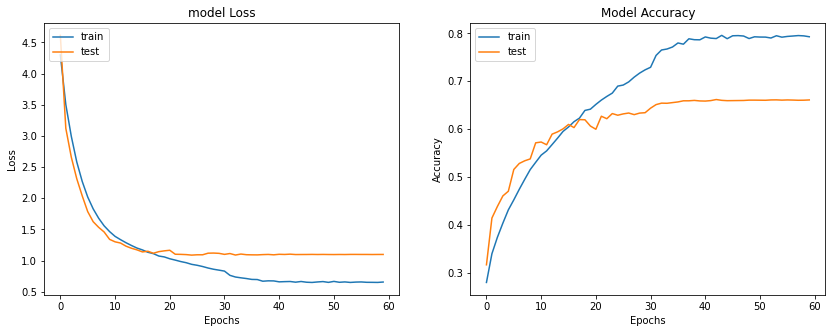

In [12]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

high accracy is achieved on training set but accuracy on validation set is stuck at 66% also no overfitting can be seen in the dataset hence is can be concluded that the inefficiency may be due to the unbalanced dataset

## 9. Model evaluation

In [13]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 4s 38ms/step - loss: 1.0976 - accuracy: 0.6609
final train accuracy = 86.61 , validation accuracy = 66.09


In [14]:
fernet.save_weights('model_weights.h5') 

## 10. Confusion Matrix & CR (Training set)

Confusion Matrix
[[ 503   59  503 1030  779  664  457]
 [  62    9   54  101   85   79   46]
 [ 579   51  516 1051  741  709  450]
 [ 909   95  939 1850 1447 1228  747]
 [ 663   68  605 1306  912  836  575]
 [ 701   63  640 1236  815  823  552]
 [ 455   38  431  789  549  549  360]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.13      0.13      3995
     disgust       0.02      0.02      0.02       436
        fear       0.14      0.13      0.13      4097
       happy       0.25      0.26      0.25      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.11      0.11      0.11      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



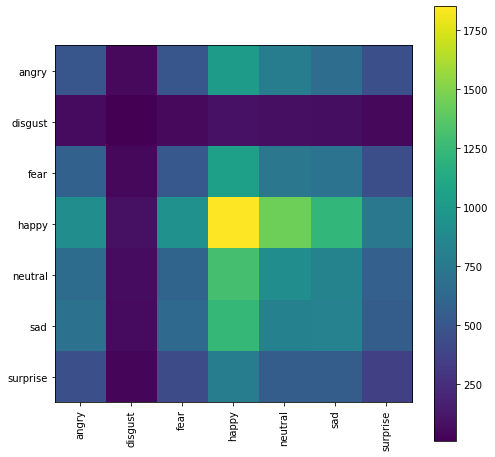

In [15]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

## 11. Confusion Matrix & CR (Test set) 

Confusion Matrix
[[121  14 107 248 192 169 107]
 [ 21   2   7  20  23  19  19]
 [148   9 110 246 200 187 124]
 [262  20 210 441 317 316 208]
 [162   8 125 291 267 219 161]
 [166  10 147 317 241 219 147]
 [119   8 103 212 169 127  93]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.13      0.12       958
     disgust       0.03      0.02      0.02       111
        fear       0.14      0.11      0.12      1024
       happy       0.25      0.25      0.25      1774
     neutral       0.19      0.22      0.20      1233
         sad       0.17      0.18      0.17      1247
    surprise       0.11      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



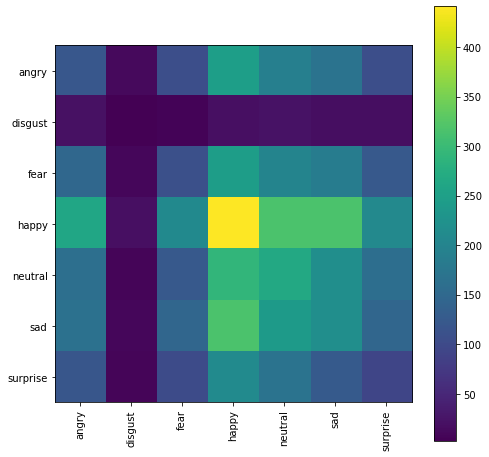

In [16]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)